### Daily versus 3-hourly CESM2 wind speed forcing

In [1]:
import xarray as xr
import numpy as np
import cmocean
import matplotlib.pyplot as plt
import glob
import pandas as pd
from datetime import datetime
import sys
sys.path.append('/home/users/birgal/')
from nemo_python_git.utils import fix_lon_range
from nemo_python_git.interpolation import regrid_to_NEMO
from nemo_python_git.file_io import find_cesm2_file

In [2]:
from nemo_python_git.forcing import cesm2_expt_all_atm_forcing, cesm2_atm_forcing

expt='LE2'
out_dir = f'/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/climate-forcing/CESM2/{expt}/proc_3h/'

In [3]:
base   = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'
dir3h  = f'{base}climate-forcing/CESM2/LE2/raw_3h/'
proc3h = f'{base}climate-forcing/CESM2/LE2/proc_3h/'
dir1da = f'{base}climate-forcing/CESM2/LE2/raw/'
dir1db = f'{base}climate-forcing/CESM2/LE2/processed/'
dir1h  = f'{base}ERA5-forcing/hourly/'

In [4]:
nemo_mask = xr.open_dataset(f'{base}bathymetry/mesh_mask-20250715.nc').squeeze()

In [5]:
year = 1920
dsu1 = xr.open_dataset(f'{base}climate-forcing/CESM2/LE2/bias-corrected-3h/multiplier077/CESM2-LE2_ens1011.001_3-hourly_UBOT_bias_corr_y{year}.nc')
dsv1 = xr.open_dataset(f'{base}climate-forcing/CESM2/LE2/bias-corrected-3h/multiplier077/CESM2-LE2_ens1011.001_3-hourly_VBOT_bias_corr_y{year}.nc')
dsu2 = xr.open_dataset(f'{base}climate-forcing/CESM2/LE2/bias-corrected-3h/multiplier081/CESM2-LE2_ens1011.001_3-hourly_UBOT_bias_corr_y{year}.nc')
dsv2 = xr.open_dataset(f'{base}climate-forcing/CESM2/LE2/bias-corrected-3h/multiplier081/CESM2-LE2_ens1011.001_3-hourly_VBOT_bias_corr_y{year}.nc')
# dsu2 = xr.open_dataset(f'{base}climate-forcing/CESM2/LE2/proc_highres_3h/CESM2-LE2_ens1011.001_bicub_eANT025_3-hourly_UBOT_y{year}.nc', decode_times=False)
# dsv2 = xr.open_dataset(f'{base}climate-forcing/CESM2/LE2/proc_highres_3h/CESM2-LE2_ens1011.001_bicub_eANT025_3-hourly_VBOT_y{year}.nc', decode_times=False)

In [68]:
ubot1 = dsu1.isel(time=dsu1.time.dt.month==1).sel(lat=slice(-90,-50)).UBOT.mean(dim='time').sortby('lon')
vbot1 = dsv1.isel(time=dsv1.time.dt.month==1).sel(lat=slice(-90,-50)).VBOT.mean(dim='time').sortby('lon')

ubot2 = dsu2.isel(time=dsu2.time.dt.month==1).sel(lat=slice(-90,-50)).UBOT.mean(dim='time').sortby('lon')
vbot2 = dsv2.isel(time=dsv2.time.dt.month==1).sel(lat=slice(-90,-50)).VBOT.mean(dim='time').sortby('lon')
# ubot2 = dsu2.isel(time_counter=slice(0,248)).UBOT.mean(dim='time_counter').drop_vars(['x','y'])
# vbot2 = dsv2.isel(time_counter=slice(0,248)).VBOT.mean(dim='time_counter').drop_vars(['x','y'])

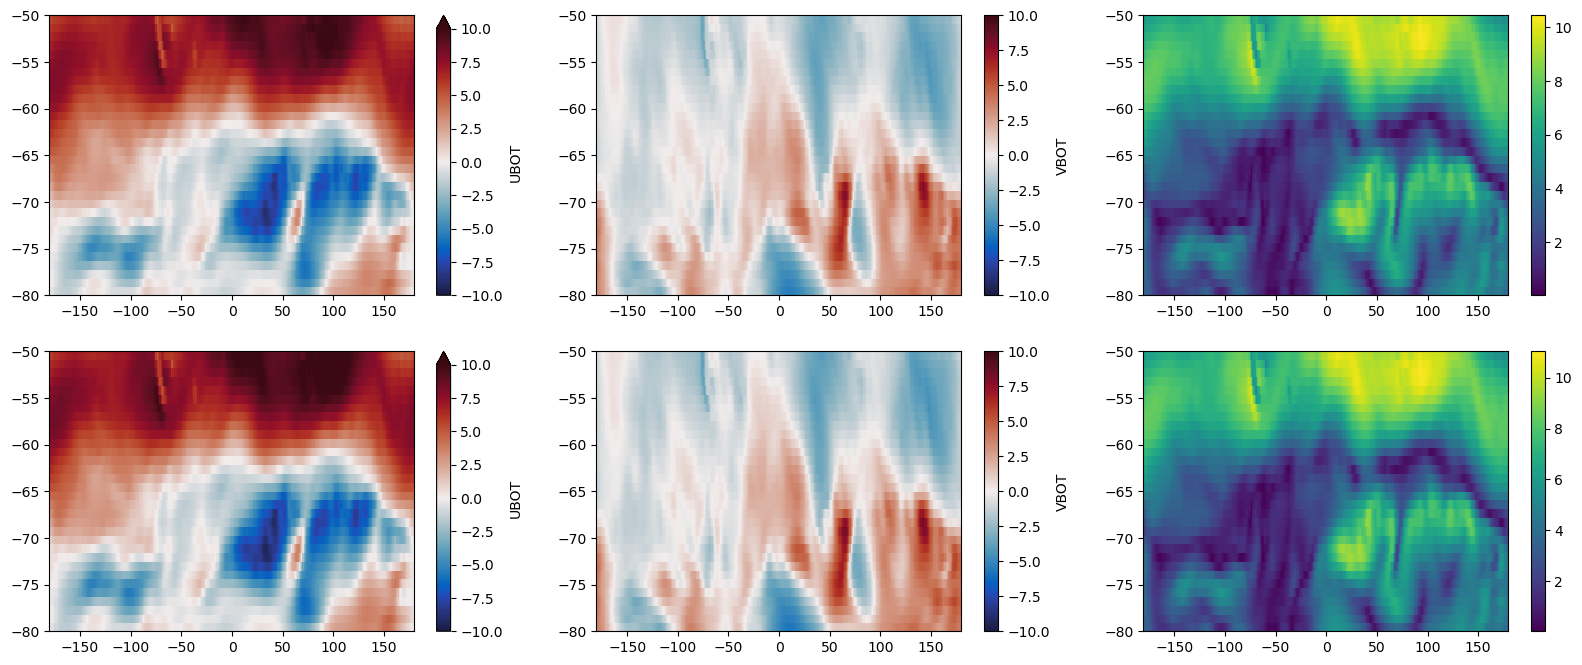

In [69]:
fig, ax = plt.subplots(2,3, figsize=(20,8))
kwags={'vmin':-10, 'vmax':10, 'cmap':cmocean.cm.balance}
ubot1.plot(ax=ax[0,0], ylim=(-80,-50), **kwags)
vbot1.plot(ax=ax[0,1], ylim=(-80,-50), **kwags)
((ubot1**2+vbot1**2)**(0.5)).plot(ax=ax[0,2], ylim=(-80,-50))
ubot2.plot(ax=ax[1,0], ylim=(-80,-50), **kwags)
vbot2.plot(ax=ax[1,1], ylim=(-80,-50), **kwags)
((ubot2**2+vbot2**2)**(0.5)).plot(ax=ax[1,2], ylim=(-80,-50))
# ubot2.where(nemo_mask.tmask.isel(nav_lev=0)==1).plot(ax=ax[1,0], ylim=(150,None))
# vbot2.where(nemo_mask.tmask.isel(nav_lev=0)==1).plot(ax=ax[1,1], ylim=(150,None))
# ((ubot2.where(nemo_mask.tmask.isel(nav_lev=0)==1)**2+vbot2.where(nemo_mask.tmask.isel(nav_lev=0)==1)**2)**(0.5)).plot(ax=ax[1,2], ylim=(150,None))

for axis in ax.ravel():
    axis.set_xlabel(''); axis.set_ylabel('');
    axis.set_title('')

In [3]:
files_proc = glob.glob(f'{proc3h}CESM2-LE2_windspeed*')
ds_ens = xr.open_mfdataset(files_proc, concat_dim='ens', combine='nested')
ds_ens.wind_speed.mean(dim='ens').to_netcdf(f'{proc3h}CESM2-LE2_windspeed_ensemble_1979-2022_mean_monthly.nc')

In [ ]:
#1988 doesn't work

In [19]:
# mask = xr.open_dataset(f'{dir1h}../ERA5-landmask.nc').rename({'latitude':'lat', 'longitude':'lon'}).isel(time=0).sel(lat=slice(-50,-80)).lsm
# mask['lon'] = fix_lon_range(mask['lon'])
dir1h  = f'{base}ERA5-forcing/hourly/'
for year in range(1986,1987):
    for month in range(1,13):
        print(year,month)
        fileu  = f'{dir1h}files/v10_y{year}m{month:02}.nc'
        era5_u = xr.open_dataset(fileu).rename({'latitude':'lat', 'longitude':'lon'}).v10.sortby('lat').sel(lat=slice(-90,-50)).resample(time="3h").mean()
        era5_u['time'] = pd.DatetimeIndex(era5_u['time'].values)
        
        era5_u.to_netcdf(f'{dir1h}files/processed/v10_3h_y{year}m{month:02}.nc')

1986 1
1986 2
1986 3
1986 4
1986 5
1986 6
1986 7
1986 8
1986 9
1986 10
1986 11
1986 12


In [88]:
# mask = xr.open_dataset(f'{dir1h}../ERA5-landmask.nc').rename({'latitude':'lat', 'longitude':'lon'}).isel(time=0).sel(lat=slice(-50,-80)).lsm
# mask['lon'] = fix_lon_range(mask['lon'])
dir1h  = f'{base}ERA5-forcing/hourly/processed/'
for year in range(1988,1989):
    for month in range(3,13):
        print(year,month)
        era5_u = xr.open_dataset(f'{dir1h}u10_3h_y{year}m{month:02}.nc')
        era5_v = xr.open_dataset(f'{dir1h}v10_3h_y{year}m{month:02}.nc')

        era5_speed = np.sqrt(era5_u.u10**2 + era5_v.v10**2).rename('wind_speed').mean(dim='time').to_dataset()
    
        era5_speed.to_netcdf(f'{dir1h}windspeed_3h_monthly_mean_y{year}m{month:02}.nc')

1988 3
1988 4
1988 5
1988 6
1988 7
1988 8
1988 9
1988 10
1988 11
1988 12


In [69]:
import re
import os
import pandas as pd

In [91]:
def preprocess(ds, filename):
    # Extract year and month from the filename using regex
    match = re.search(r'y(\d{4})m(\d{2})', os.path.basename(filename))
    if match:
        year = int(match.group(1))
        month = int(match.group(2))
        time = pd.Timestamp(f'{year}-{month:02d}-01')
    else:
        raise ValueError(f"Could not extract date from filename: {filename}")
    
    # Add a new time dimension
    ds = ds.expand_dims({'time': [time]})
    return ds
    
datasets = []
for file in glob.glob(f'{dir1h}windspeed_3h_monthly_mean_y*'):
    ds = xr.open_dataset(file)
    ds = preprocess(ds, file)
    datasets.append(ds)

# Concatenate manually
ds_comb = xr.concat(datasets, dim='time')
ds_comb.wind_speed.groupby('time.month').mean(dim='time').to_netcdf(f'{dir1h}windspeed_1979-2022_mean_monthly.nc')

In [122]:
from scipy.interpolate import NearestNDInterpolator

In [136]:
# load files and mask land before regridding 
cesm2_ds        = xr.open_dataset(f'{proc3h}CESM2-LE2_windspeed_ensemble_1979-2022_mean_monthly.nc').mean(dim='month')
cesm2_ds['lon'] = fix_lon_range(cesm2_ds['lon'])
cesm2_ds        = cesm2_ds.sortby('lon')

cesm2_mask = xr.open_dataset(f'{dir1da}b.e21.BHISTsmbb.f09_g17.LE2-1011.001.cam.h0.LANDFRAC.185001-185912.nc').LANDFRAC.isel(time=0)
cesm2_mask['lon'] = fix_lon_range(cesm2_mask['lon'])
cesm2_ds   = cesm2_ds.where(cesm2_mask==0)

indices = np.where(np.isfinite(cesm2_ds.wind_speed))
interp  = NearestNDInterpolator(np.transpose(indices), cesm2_ds.wind_speed.data[indices])
cesm2_ds['wind_speed'] = (('lat','lon'), interp(*np.indices(cesm2_ds.wind_speed.shape)))

era5_ds         = xr.open_dataset(f'{dir1h}processed/windspeed_1979-2022_mean_monthly.nc').mean(dim='month')
era5_ds['lon']  = fix_lon_range(era5_ds['lon'])
era5_ds         = era5_ds.sortby('lon')

era5_mask = xr.open_dataset(f'{dir1h}../ERA5-landmask.nc').rename({'latitude':'lat', 'longitude':'lon'}).isel(time=0).sel(lat=slice(-50,-90)).lsm
era5_mask['lon'] = fix_lon_range(era5_mask['lon'])
era5_ds   = era5_ds.where(era5_mask==0)

indices = np.where(np.isfinite(era5_ds.wind_speed))
interp  = NearestNDInterpolator(np.transpose(indices), era5_ds.wind_speed.data[indices])
era5_ds['wind_speed'] = (('lat','lon'), interp(*np.indices(era5_ds.wind_speed.shape)))

# regrid
cesm2_nemo = regrid_to_NEMO(cesm2_ds, 'wind_speed')
era5_nemo  = regrid_to_NEMO(era5_ds, 'wind_speed')

Interpolating
Interpolating


In [6]:
ds = xr.open_dataset(f'{base}climate-forcing/CESM2/LE2/proc_3h/CESM2-LE2_ens1011.001_UBOT_y1850.nc')

In [137]:
nemo_mask = xr.open_dataset(f'{base}bathymetry/mesh_mask-20250715.nc').squeeze()

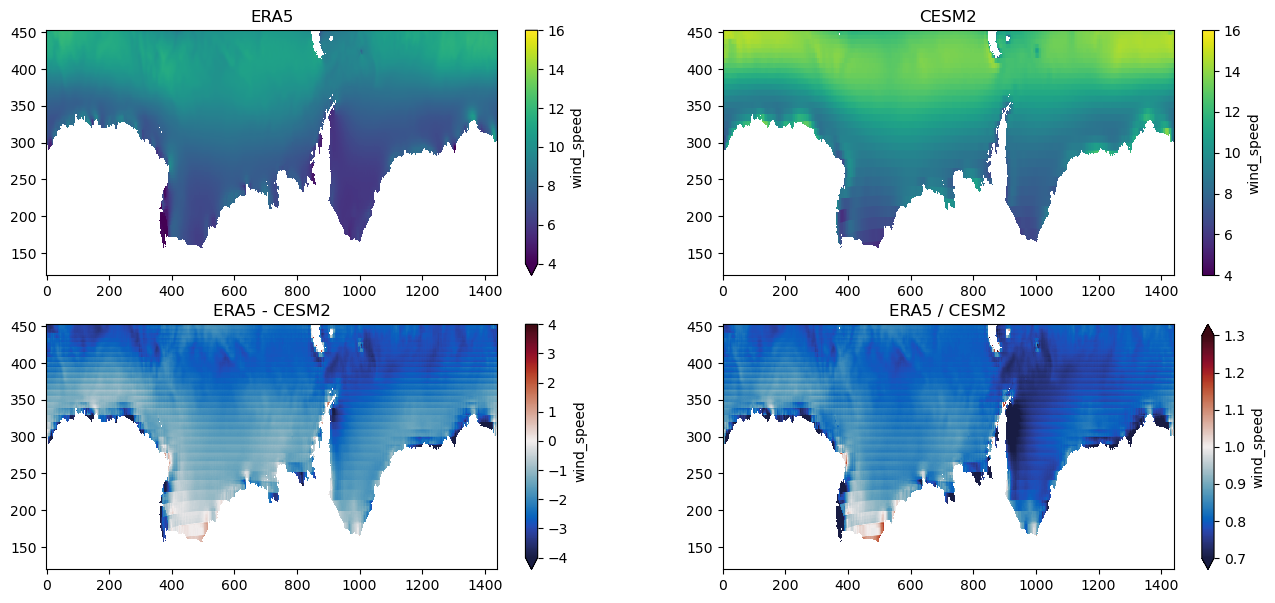

In [118]:
fig, ax = plt.subplots(2,2, figsize=(16,7))
kwags = {'ylim':(120,None), 'vmin':4, 'vmax':16}
kwags_diff1 = {'ylim':(120,None), 'vmin':-4, 'vmax':4, 'cmap':cmocean.cm.balance}
kwags_diff2 = {'ylim':(120,None), 'vmin':0.7, 'vmax':1.3, 'cmap':cmocean.cm.balance}
era5_nemo.wind_speed.where(nemo_mask.tmask.isel(nav_lev=0) == 1).plot(ax=ax[0,0], **kwags)
cesm2_nemo.wind_speed.where(nemo_mask.tmask.isel(nav_lev=0) == 1).plot(ax=ax[0,1], **kwags)
(era5_nemo.wind_speed - cesm2_nemo.wind_speed).where(nemo_mask.tmask.isel(nav_lev=0) == 1).plot(ax=ax[1,0], **kwags_diff1)
(era5_nemo.wind_speed/cesm2_nemo.wind_speed).where(nemo_mask.tmask.isel(nav_lev=0) == 1).plot(ax=ax[1,1], **kwags_diff2)
ax[0,0].set_title('ERA5')
ax[0,1].set_title('CESM2')
ax[1,0].set_title('ERA5 - CESM2')
ax[1,1].set_title('ERA5 / CESM2')
for axis in ax.ravel():
    axis.set_xlabel(''); axis.set_ylabel('');

In [3]:
from nemo_python_git.file_io import find_cesm2_file

In [4]:
find_cesm2_file('LE2', 'UBOT', 'atm', '3-hourly', '1011.001', 1850)

'/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/climate-forcing/CESM2/LE2/raw/b.e21.BHISTsmbb.f09_g17.LE2-1011.001.cam.h3.UBOT.1850010100-1860010100.nc'

In [139]:
(era5_nemo.wind_speed/cesm2_nemo.wind_speed).where(nemo_mask.tmask.isel(nav_lev=0) == 1).mean()

<xarray.DataArray 'wind_speed' ()> Size: 8B
array(0.81374187)
Coordinates:
    nav_lev       float32 4B 0.4921
    time_counter  float32 4B 0.0

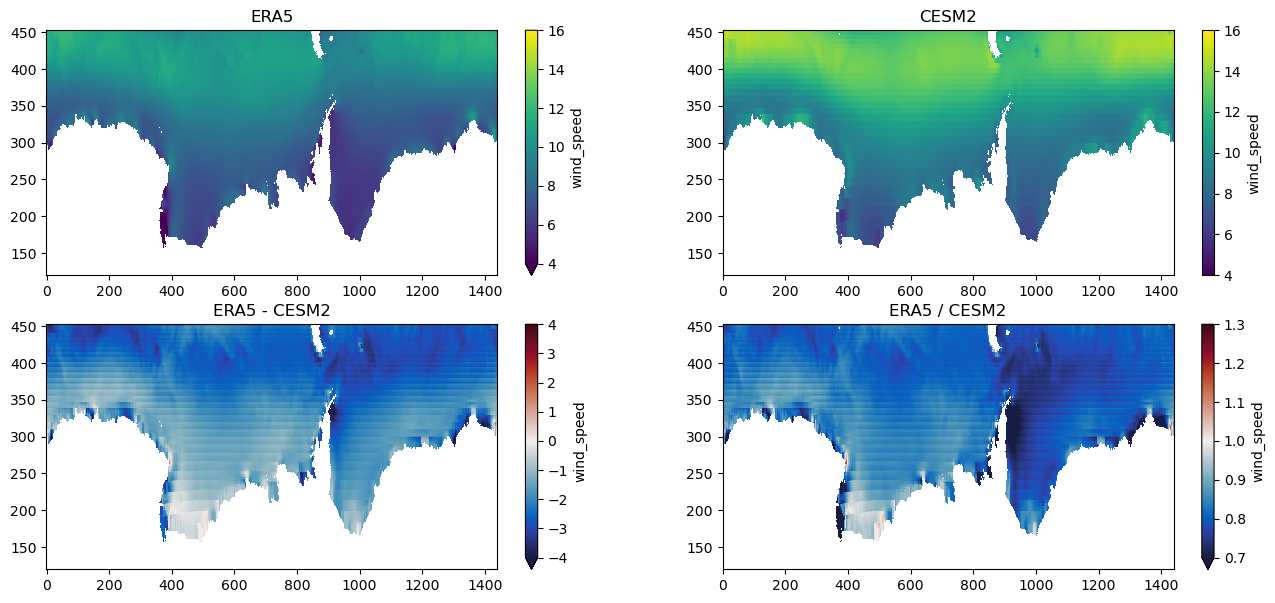

In [138]:
fig, ax = plt.subplots(2,2, figsize=(16,7))
kwags = {'ylim':(120,None), 'vmin':4, 'vmax':16}
kwags_diff1 = {'ylim':(120,None), 'vmin':-4, 'vmax':4, 'cmap':cmocean.cm.balance}
kwags_diff2 = {'ylim':(120,None), 'vmin':0.7, 'vmax':1.3, 'cmap':cmocean.cm.balance}
era5_nemo.wind_speed.where(nemo_mask.tmask.isel(nav_lev=0) == 1).plot(ax=ax[0,0], **kwags)
cesm2_nemo.wind_speed.where(nemo_mask.tmask.isel(nav_lev=0) == 1).plot(ax=ax[0,1], **kwags)
(era5_nemo.wind_speed - cesm2_nemo.wind_speed).where(nemo_mask.tmask.isel(nav_lev=0) == 1).plot(ax=ax[1,0], **kwags_diff1)
(era5_nemo.wind_speed/cesm2_nemo.wind_speed).where(nemo_mask.tmask.isel(nav_lev=0) == 1).plot(ax=ax[1,1], **kwags_diff2)
ax[0,0].set_title('ERA5')
ax[0,1].set_title('CESM2')
ax[1,0].set_title('ERA5 - CESM2')
ax[1,1].set_title('ERA5 / CESM2')
for axis in ax.ravel():
    axis.set_xlabel(''); axis.set_ylabel('');

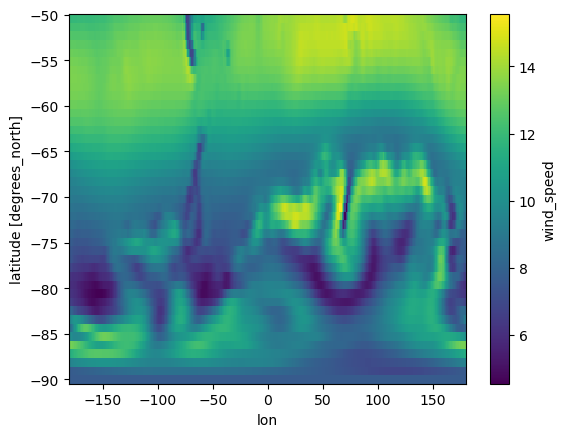

In [101]:
cesm2_ds.wind_speed.plot()

In [34]:
def load_ds(path, var, year=1979, month=1, mask=True):

    ds        = xr.open_dataset(path)[var].sel(lat=slice(-80,-50))
    ds['lon'] = fix_lon_range(ds['lon'])
    
    if mask:
        landmask = xr.open_dataset(f'{dir1da}b.e21.BHISTsmbb.f09_g17.LE2-1011.001.cam.h0.LANDFRAC.185001-185912.nc').LANDFRAC.isel(time=0)
        landmask['lon'] = fix_lon_range(landmask['lon'])
        ds = ds.where(landmask==0)

    ds = ds.isel(time=(ds.time.dt.year==year)*(ds.time.dt.month==month)).sortby('lon')

    return ds

In [35]:
year=1979
month=1

ds_1d_U10x = load_ds(f'{dir1db}CESM2-LE2_ens1011.001_U10x_y{year}.nc', 'U10x', year=year, month=month)
ds_1d_U10y = load_ds(f'{dir1db}CESM2-LE2_ens1011.001_U10y_y{year}.nc', 'U10y', year=year, month=month)
ds_1d_UBOT = load_ds(f'{dir1da}b.e21.BHISTsmbb.f09_g17.LE2-1011.001.cam.h1.UBOT.19700101-19791231.nc', 'UBOT', year=year, month=month)
ds_1d_VBOT = load_ds(f'{dir1da}b.e21.BHISTsmbb.f09_g17.LE2-1011.001.cam.h1.VBOT.19700101-19791231.nc', 'VBOT', year=year, month=month)
ds_3h_UBOT = load_ds(f'{dir3h}b.e21.BHISTsmbb.f09_g17.LE2-1011.001.cam.h3.UBOT.1970010100-1980010100.nc', 'UBOT', year=year, month=month)
ds_3h_VBOT = load_ds(f'{dir3h}b.e21.BHISTsmbb.f09_g17.LE2-1011.001.cam.h3.VBOT.1970010100-1980010100.nc', 'VBOT', year=year, month=month)

ds_3h_UBOT['speed'] = np.sqrt(ds_3h_UBOT**2 + ds_3h_VBOT**2)
ds_1d_UBOT['speed'] = np.sqrt(ds_1d_UBOT**2 + ds_1d_VBOT**2)
ds_1d_U10x['speed'] = np.sqrt(ds_1d_U10x**2 + ds_1d_U10y**2)

Text(0.5, 0.98, 'Averaged over 1979-01')

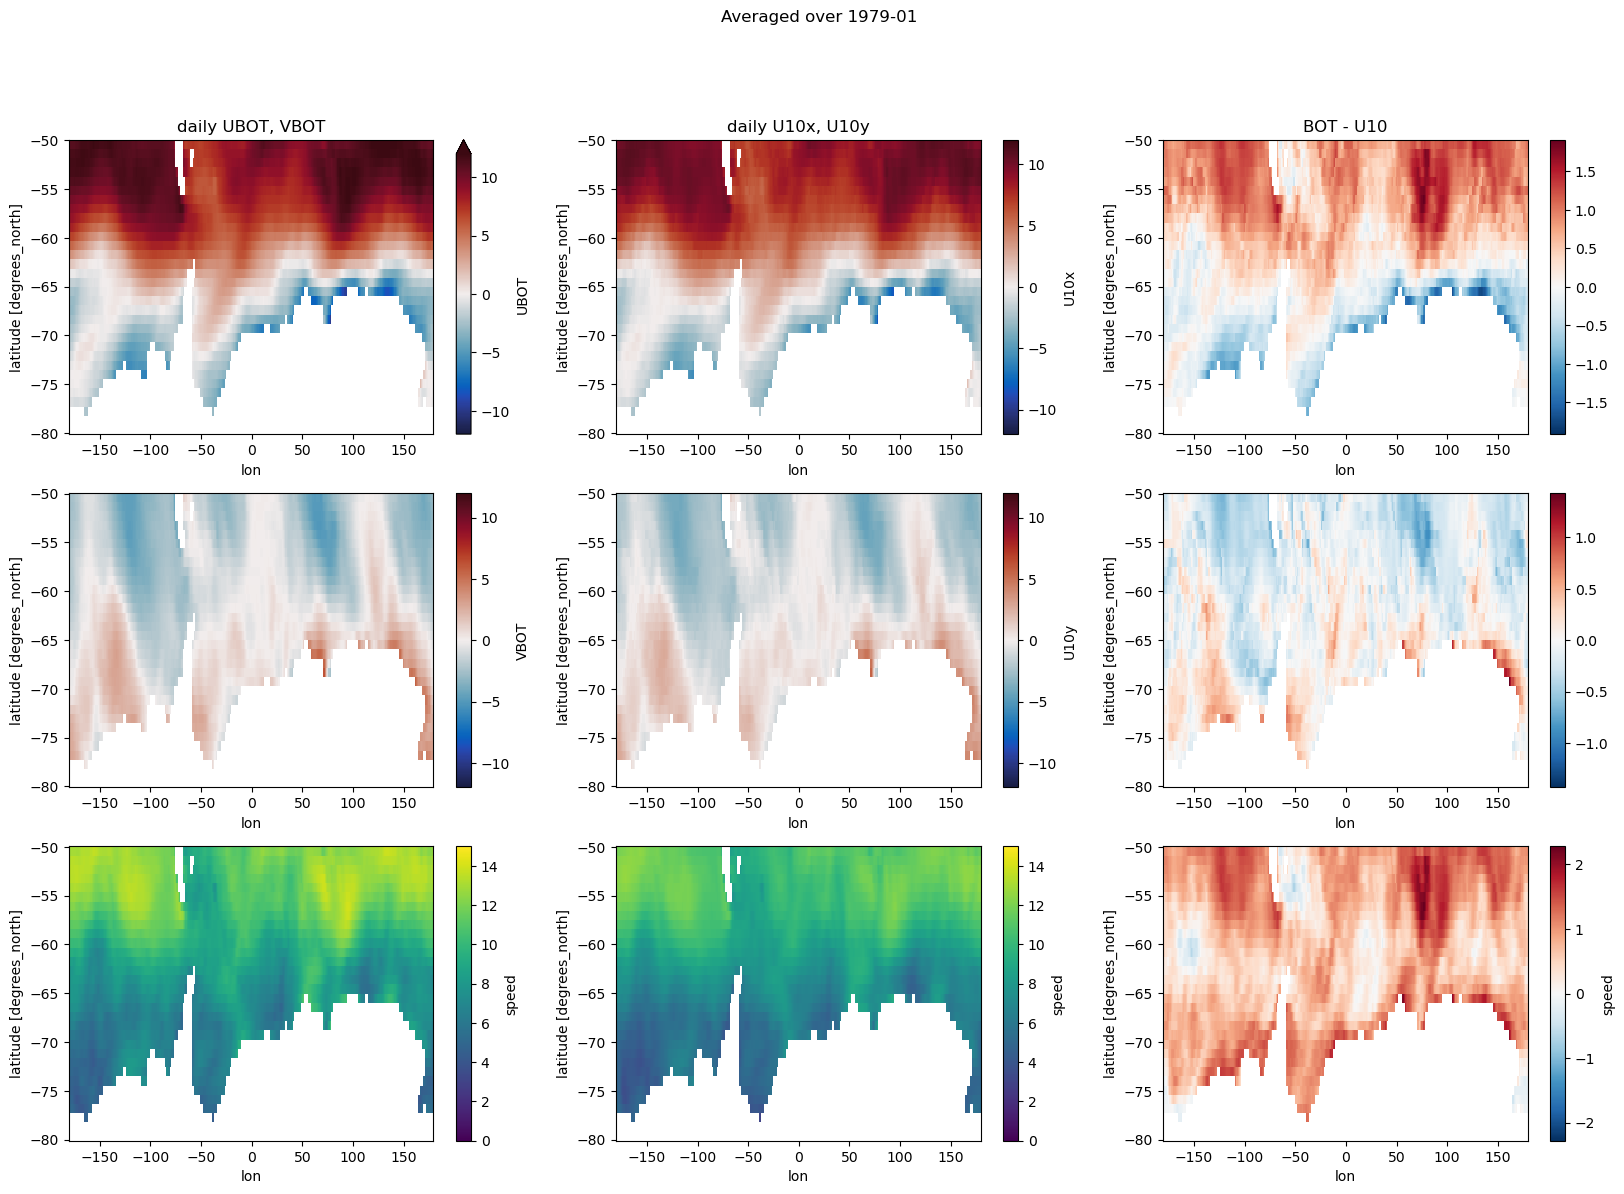

In [36]:
fig, ax = plt.subplots(3,3, figsize=(20,13))
kwags1 = {'vmin':-12, 'vmax':12, 'cmap':cmocean.cm.balance}
kwags2 = {'vmin':0, 'vmax':15, 'cmap':cmocean.cm.balance}

ds_1d_UBOT.mean(dim='time').plot(ax=ax[0,0], **kwags1)
ds_1d_U10x.mean(dim='time').plot(ax=ax[0,1], **kwags1)
(ds_1d_UBOT.mean(dim='time') - ds_1d_U10x.mean(dim='time')).plot(ax=ax[0,2])

ds_1d_VBOT.mean(dim='time').plot(ax=ax[1,0], **kwags1)
ds_1d_U10y.mean(dim='time').plot(ax=ax[1,1], **kwags1)
(ds_1d_VBOT.mean(dim='time') - ds_1d_U10y.mean(dim='time')).plot(ax=ax[1,2])

ds_1d_UBOT['speed'].mean(dim='time').plot(ax=ax[2,0], vmin=0, vmax=15)
ds_1d_U10x['speed'].mean(dim='time').plot(ax=ax[2,1], vmin=0, vmax=15)
(ds_1d_UBOT['speed'].mean(dim='time') - ds_1d_U10x['speed'].mean(dim='time')).plot(ax=ax[2,2])

ax[0,0].set_title('daily UBOT, VBOT')
ax[0,1].set_title('daily U10x, U10y')
ax[0,2].set_title('BOT - U10')

fig.suptitle(f'Averaged over {year}-{month:02}')

In [15]:
# load some ERA5 results as well:
ds_1h_era5 = xr.open_dataset(f'{base}ERA5-forcing/hourly/ERA5_1h_windspeed_y{year}m{month:02}_mean.nc').sel(latitude=slice(-80,-50))

Text(0.5, 0.98, 'Averaged over 1979-01')

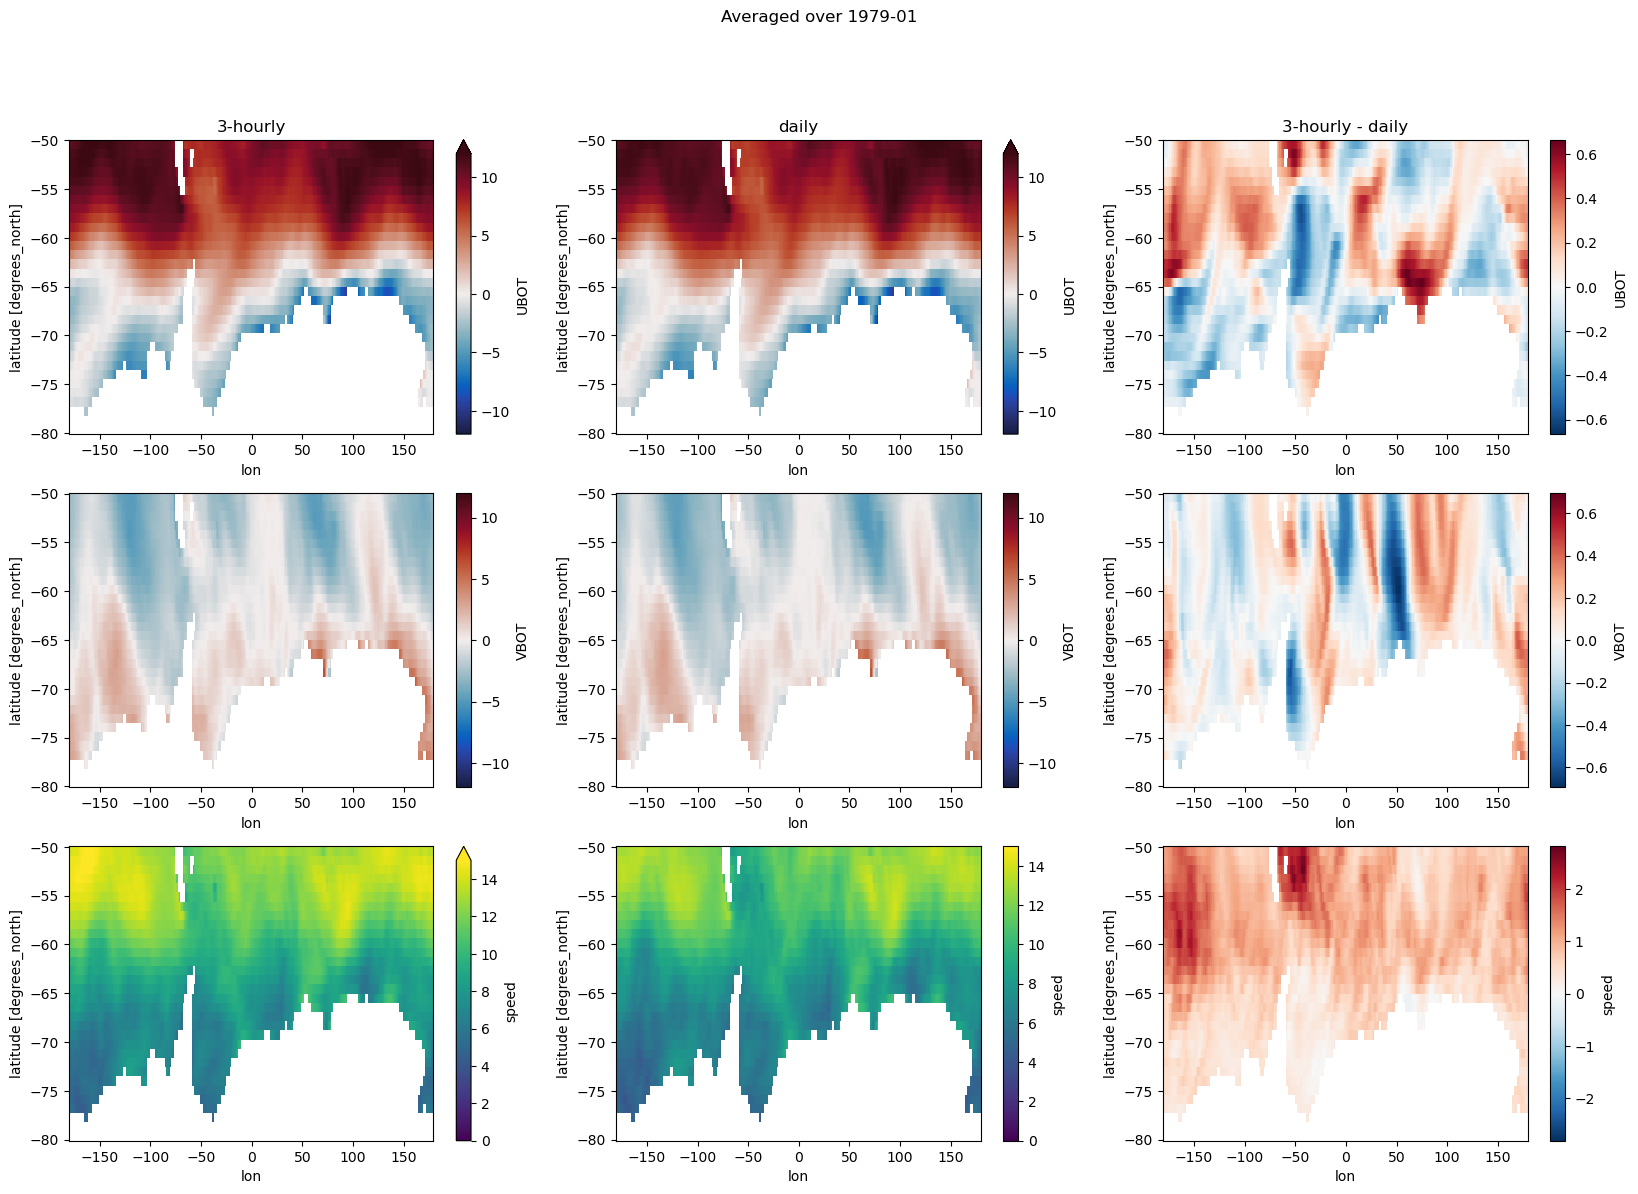

In [18]:
fig, ax = plt.subplots(3,3, figsize=(20,13))
kwags1 = {'vmin':-12, 'vmax':12, 'cmap':cmocean.cm.balance}
kwags2 = {'vmin':0, 'vmax':15, 'cmap':cmocean.cm.balance}

ds_3h_UBOT.mean(dim='time').plot(ax=ax[0,0], **kwags1)
ds_1d_UBOT.mean(dim='time').plot(ax=ax[0,1], **kwags1)
(ds_3h_UBOT.mean(dim='time') - ds_1d_UBOT.mean(dim='time')).plot(ax=ax[0,2])

ds_3h_VBOT.mean(dim='time').plot(ax=ax[1,0], **kwags1)
ds_1d_VBOT.mean(dim='time').plot(ax=ax[1,1], **kwags1)
(ds_3h_VBOT.mean(dim='time') - ds_1d_VBOT.mean(dim='time')).plot(ax=ax[1,2])

ds_3h_UBOT['speed'].mean(dim='time').plot(ax=ax[2,0], vmin=0, vmax=15)
ds_1d_UBOT['speed'].mean(dim='time').plot(ax=ax[2,1], vmin=0, vmax=15)
# ds_1h_era5.wind_speed.plot(ax=ax[2,1], vmin=0, vmax=15)
(ds_3h_UBOT['speed'].mean(dim='time') - ds_1d_UBOT['speed'].mean(dim='time')).plot(ax=ax[2,2])

ax[0,0].set_title('3-hourly')
ax[0,1].set_title('daily')
ax[0,2].set_title('3-hourly - daily')

fig.suptitle(f'Averaged over {year}-{month:02}')

Text(0.5, 0.98, 'Averaged over 1979-01')

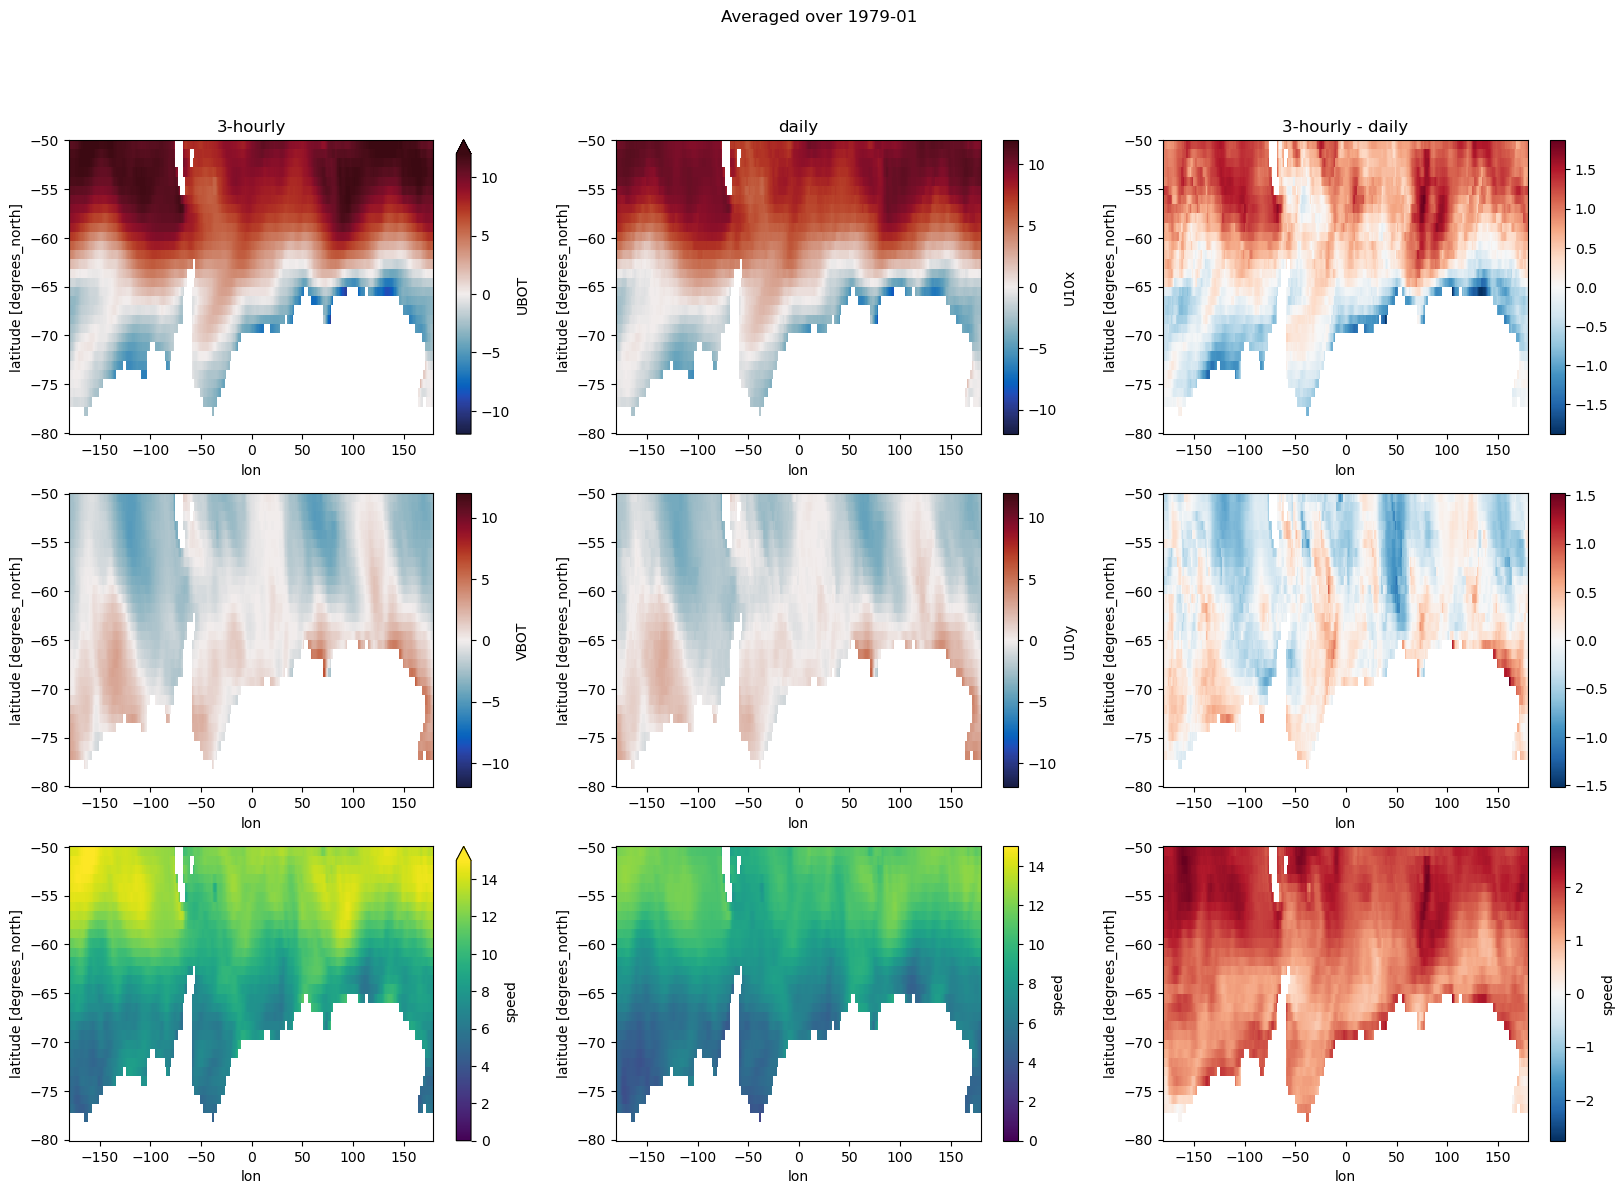

In [23]:
fig, ax = plt.subplots(3,3, figsize=(20,13))
kwags1 = {'vmin':-12, 'vmax':12, 'cmap':cmocean.cm.balance}
kwags2 = {'vmin':0, 'vmax':15, 'cmap':cmocean.cm.balance}

ds_3h_UBOT.mean(dim='time').plot(ax=ax[0,0], **kwags1)
ds_1d_U10x.mean(dim='time').plot(ax=ax[0,1], **kwags1)
(ds_3h_UBOT.mean(dim='time') - ds_1d_U10x.mean(dim='time')).plot(ax=ax[0,2])

ds_3h_VBOT.mean(dim='time').plot(ax=ax[1,0], **kwags1)
ds_1d_U10y.mean(dim='time').plot(ax=ax[1,1], **kwags1)
(ds_3h_VBOT.mean(dim='time') - ds_1d_U10y.mean(dim='time')).plot(ax=ax[1,2])

ds_3h_UBOT['speed'].mean(dim='time').plot(ax=ax[2,0], vmin=0, vmax=15)
ds_1d_U10x['speed'].mean(dim='time').plot(ax=ax[2,1], vmin=0, vmax=15)
# ds_1h_era5.wind_speed.plot(ax=ax[2,1], vmin=0, vmax=15)
(ds_3h_UBOT['speed'].mean(dim='time') - ds_1d_U10x['speed'].mean(dim='time')).plot(ax=ax[2,2])

ax[0,0].set_title('3-hourly')
ax[0,1].set_title('daily')
ax[0,2].set_title('3-hourly - daily')

fig.suptitle(f'Averaged over {year}-{month:02}')

In [62]:
# load ERA5 daily and hourly derived mean wind speeds to compare against:
era5_1h   = xr.open_dataset(f'{base}ERA5-forcing/hourly/ERA5_1h_windspeed_y1979m01_mean.nc').rename({'latitude':'lat', 'longitude':'lon'})
era5_1h_u = xr.open_dataset(f'{base}ERA5-forcing/hourly/u10_y1979m01.nc').rename({'latitude':'lat', 'longitude':'lon'}).u10.sortby('lat').sel(lat=slice(-90,-50))
era5_1h_v = xr.open_dataset(f'{base}ERA5-forcing/hourly/v10_y1979m01.nc').rename({'latitude':'lat', 'longitude':'lon'}).v10.sortby('lat').sel(lat=slice(-90,-50))

era5_1d_u = xr.open_dataset(f'{base}ERA5-forcing/daily/files/processed/u10_time_y1979.nc').rename({'latitude':'lat', 'longitude':'lon'}).u10.sortby('lat').sel(lat=slice(-90,-50)).isel(time=slice(0,31))
era5_1d_v = xr.open_dataset(f'{base}ERA5-forcing/daily/files/processed/v10_time_y1979.nc').rename({'latitude':'lat', 'longitude':'lon'}).v10.sortby('lat').sel(lat=slice(-90,-50)).isel(time=slice(0,31))

era5_1d = np.sqrt(era5_1d_u**2 + era5_1d_v**2).rename('wind_speed').mean(dim='time').to_dataset()

era5_1h['lon'] = fix_lon_range(era5_1h['lon'])
era5_1h = era5_1h.sortby('lon')

In [65]:
era5_3h_u = era5_1h_u.resample(time="3h").mean()
era5_3h_v = era5_1h_v.resample(time="3h").mean()

era5_3h = np.sqrt(era5_3h_u**2 + era5_3h_v**2).rename('wind_speed').mean(dim='time').to_dataset()
era5_3h['lon'] = fix_lon_range(era5_3h['lon'])
era5_3h = era5_3h.sortby('lon')

In [50]:
dirf1h = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/ERA5-forcing/hourly/'
mask = xr.open_dataset(f'{dirf1h}../ERA5-landmask.nc').rename({'latitude':'lat', 'longitude':'lon'}).isel(time=0).sel(lat=slice(-50,-80)).lsm
mask['lon'] = fix_lon_range(mask['lon'])

Text(0.5, 0.98, 'Averaged over 1979-01')

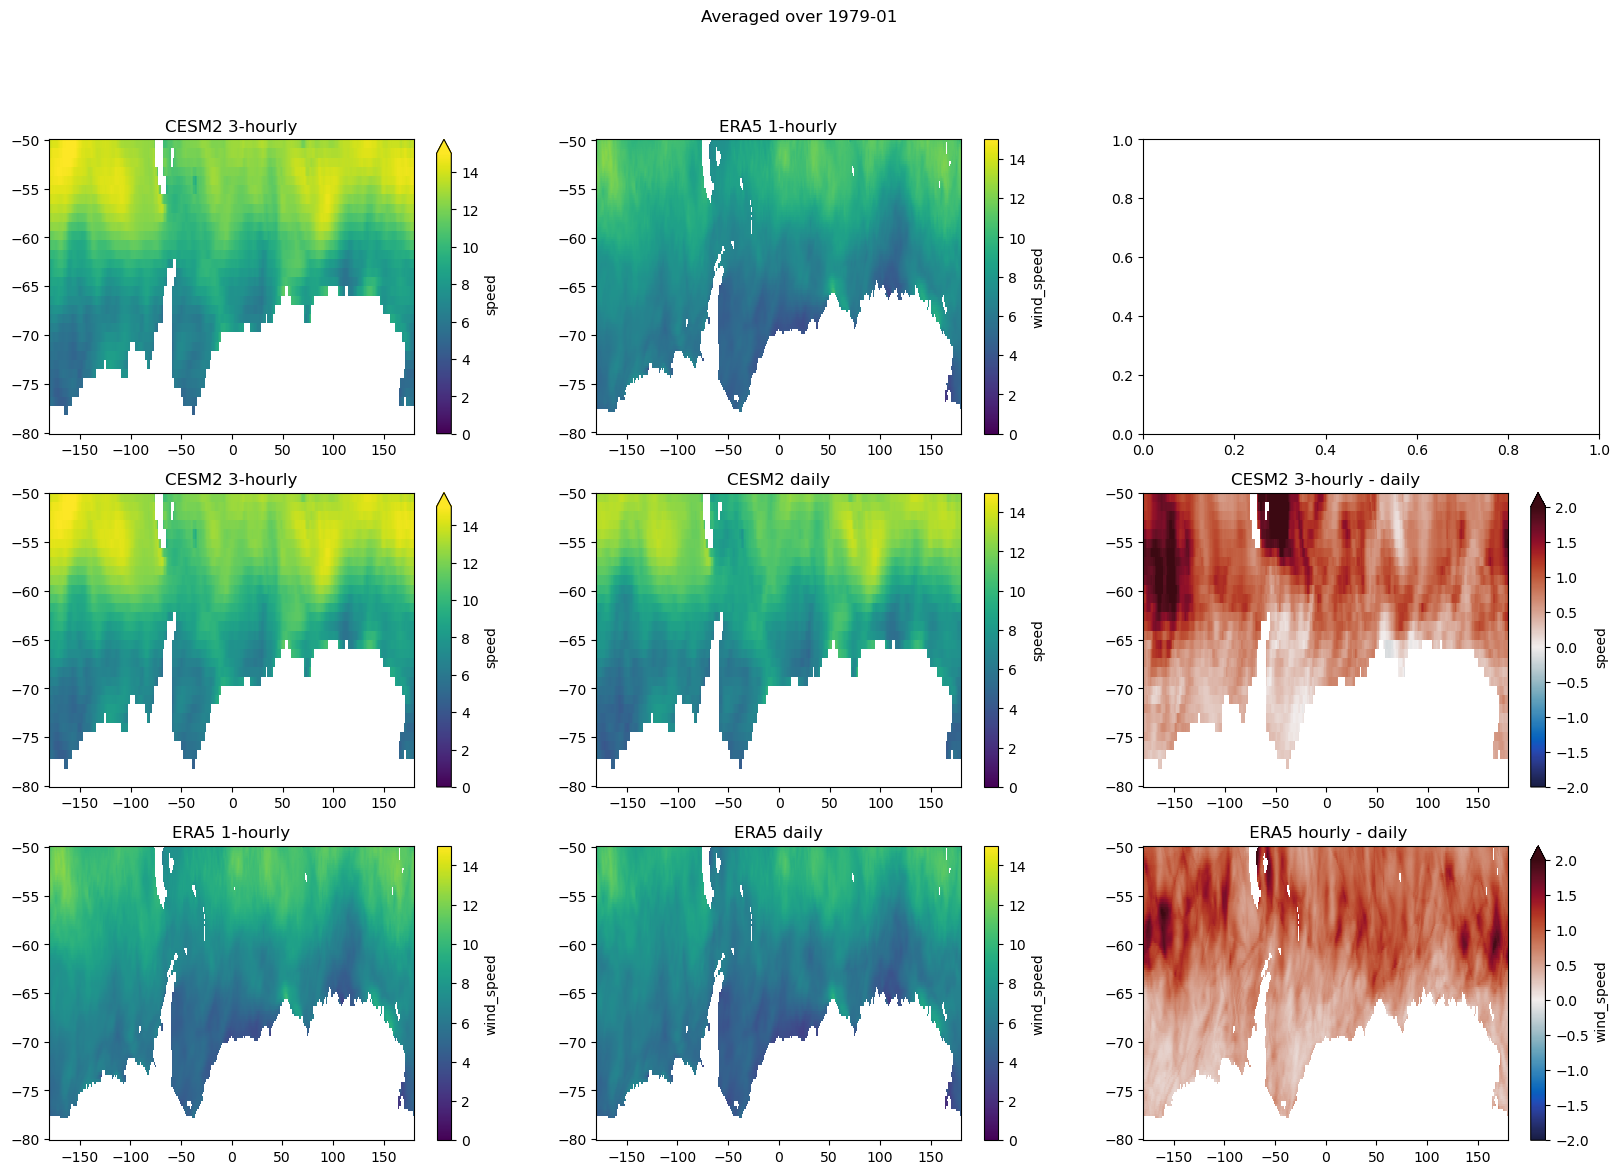

In [60]:
fig, ax = plt.subplots(3,3, figsize=(20,13))
kwags1 = {'vmin':-2, 'vmax':2, 'cmap':cmocean.cm.balance}
kwags2 = {'vmin':0, 'vmax':15, 'cmap':cmocean.cm.balance}

ds_3h_UBOT['speed'].mean(dim='time').plot(ax=ax[0,0], vmin=0, vmax=15)
era5_1h['wind_speed'].where(mask==0).plot(ax=ax[0,1], vmin=0, vmax=15)

ds_3h_UBOT['speed'].mean(dim='time').plot(ax=ax[1,0], vmin=0, vmax=15)
ds_1d_UBOT['speed'].mean(dim='time').plot(ax=ax[1,1], vmin=0, vmax=15)
(ds_3h_UBOT['speed'].mean(dim='time') - ds_1d_UBOT['speed'].mean(dim='time')).plot(ax=ax[1,2], **kwags1)

era5_1h['wind_speed'].where(mask==0).plot(ax=ax[2,0], vmin=0, vmax=15)
era5_1d['wind_speed'].where(mask==0).plot(ax=ax[2,1], vmin=0, vmax=15)
(era5_1h['wind_speed'].where(mask==0) - era5_1d['wind_speed'].where(mask==0)).plot(ax=ax[2,2], **kwags1)

ax[0,0].set_title('CESM2 3-hourly')
ax[0,1].set_title('ERA5 1-hourly')
ax[1,0].set_title('CESM2 3-hourly')
ax[1,1].set_title('CESM2 daily')
ax[1,2].set_title('CESM2 3-hourly - daily')
ax[2,0].set_title('ERA5 1-hourly')
ax[2,1].set_title('ERA5 daily')
ax[2,2].set_title(' ERA5 hourly - daily')
for axis in ax.ravel():
    axis.set_xlabel('')
    axis.set_ylabel('')

fig.suptitle(f'Averaged over {year}-{month:02}')

Text(0.5, 0.98, 'Averaged over 1979-01')

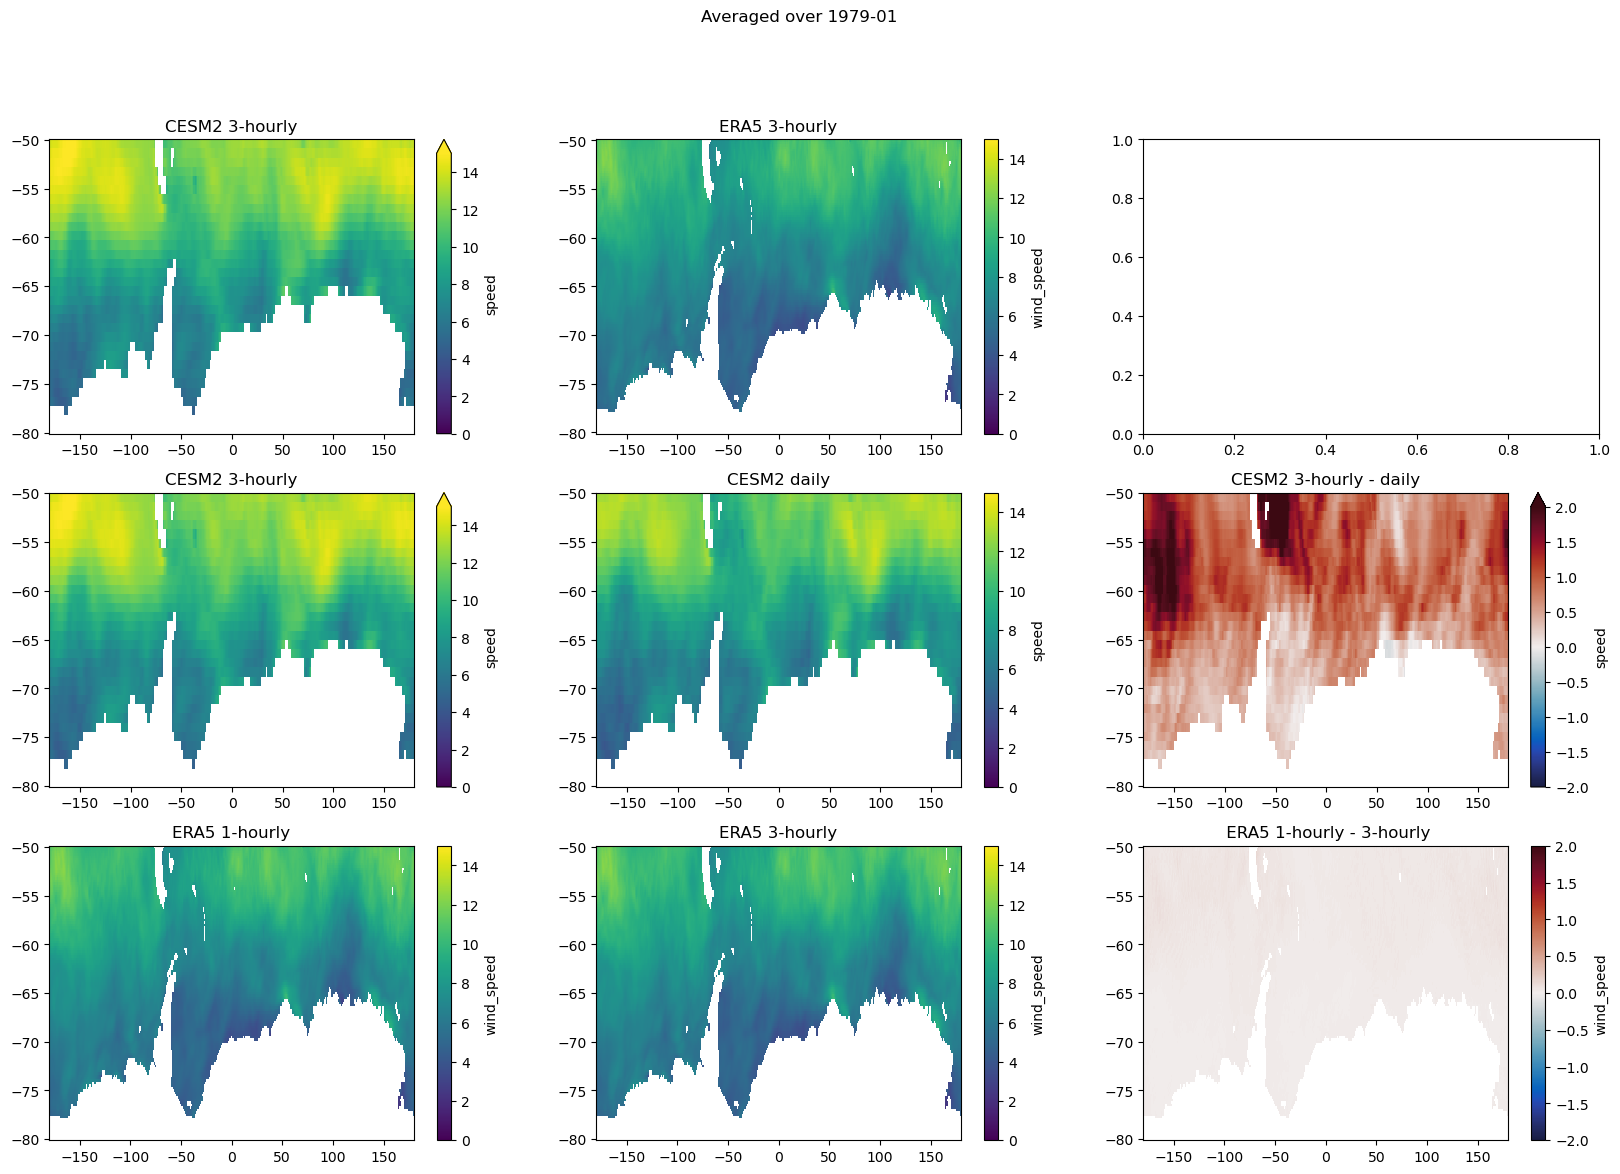

In [68]:
fig, ax = plt.subplots(3,3, figsize=(20,13))
kwags1 = {'vmin':-2, 'vmax':2, 'cmap':cmocean.cm.balance}
kwags2 = {'vmin':0, 'vmax':15, 'cmap':cmocean.cm.balance}

ds_3h_UBOT['speed'].mean(dim='time').plot(ax=ax[0,0], vmin=0, vmax=15)
era5_3h['wind_speed'].where(mask==0).plot(ax=ax[0,1], vmin=0, vmax=15)

ds_3h_UBOT['speed'].mean(dim='time').plot(ax=ax[1,0], vmin=0, vmax=15)
ds_1d_UBOT['speed'].mean(dim='time').plot(ax=ax[1,1], vmin=0, vmax=15)
(ds_3h_UBOT['speed'].mean(dim='time') - ds_1d_UBOT['speed'].mean(dim='time')).plot(ax=ax[1,2], **kwags1)

era5_1h['wind_speed'].where(mask==0).plot(ax=ax[2,0], vmin=0, vmax=15)
era5_3h['wind_speed'].where(mask==0).plot(ax=ax[2,1], vmin=0, vmax=15)
(era5_1h['wind_speed'].where(mask==0) - era5_3h['wind_speed'].where(mask==0)).plot(ax=ax[2,2], **kwags1)

ax[0,0].set_title('CESM2 3-hourly')
ax[0,1].set_title('ERA5 3-hourly')
ax[1,0].set_title('CESM2 3-hourly')
ax[1,1].set_title('CESM2 daily')
ax[1,2].set_title('CESM2 3-hourly - daily')
ax[2,0].set_title('ERA5 1-hourly')
ax[2,1].set_title('ERA5 3-hourly')
ax[2,2].set_title(' ERA5 1-hourly - 3-hourly')
for axis in ax.ravel():
    axis.set_xlabel('')
    axis.set_ylabel('')

fig.suptitle(f'Averaged over {year}-{month:02}')